In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import ppscore as pps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


DataFrame Creation 

In [75]:
df = pd.read_csv("Fraud.csv")
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


BASIC EDA

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [77]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [78]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [79]:
df.shape

(6362620, 11)

Label Encoder -> To encode the categorical column as given in df.info()

In [80]:
def labelencoder(df):
    le = LabelEncoder()
    col = df.select_dtypes(include = 'object').columns
    for i in col:
        df[i] = le.fit_transform(df[i])
    
    return df


For Better Understandability making a new Dataframe

In [81]:
df1 = labelencoder(df)


In [82]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


Correlation Matrix -> To get better understanding about the relationship of target with other features

In [83]:
cor = df1.corr()
cor_table = cor['isFraud'].sort_values(ascending=False)
print(cor_table)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
type              0.020833
oldbalanceOrg     0.010154
newbalanceDest    0.000535
nameOrig         -0.000464
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
nameDest         -0.021963
Name: isFraud, dtype: float64


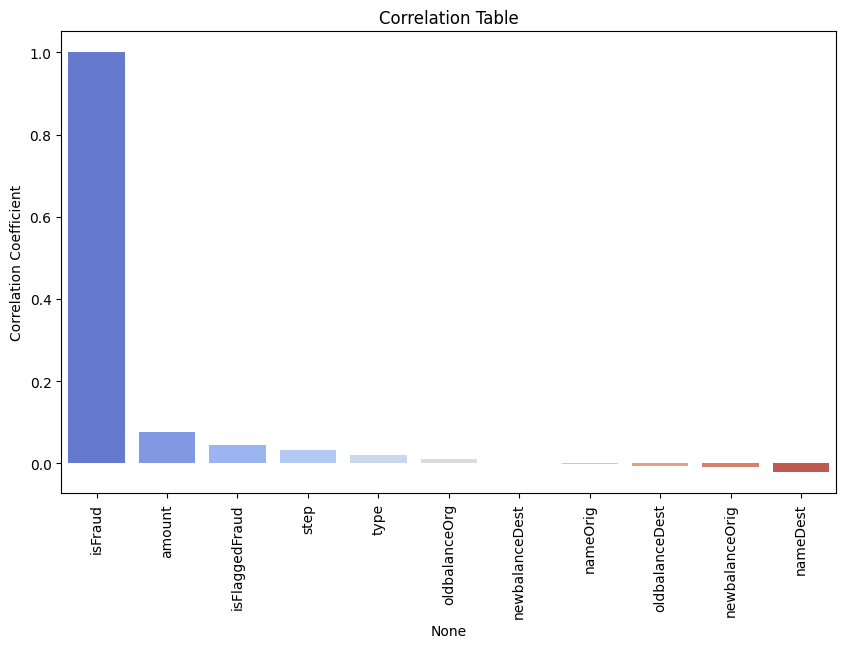

In [84]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cor_table.index, y=cor_table.values, hue=cor_table.index, palette="coolwarm", legend=False)
plt.xticks(rotation=90)
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Table")
plt.show()

In [85]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB


In [86]:
x = [col for col in df1.columns if col != 'isFraud']
y = 'isFraud'

print(x)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


In [87]:
dfx = df1[x]

x_const = add_constant(dfx)
vif_data = pd.DataFrame()
vif_data["Feature"] = dfx.columns
vif_data["VIF"] = [variance_inflation_factor(x_const.values, i + 1) for i in range(len(dfx.columns))]  # +1 because of constant at index 0

print(vif_data.sort_values(by="VIF", ascending=False))

          Feature         VIF
5  newbalanceOrig  468.010508
4   oldbalanceOrg  462.607845
8  newbalanceDest   75.806088
7  oldbalanceDest   65.980405
2          amount    3.774661
1            type    1.939473
6        nameDest    1.675392
0            step    1.002531
9  isFlaggedFraud    1.000610
3        nameOrig    1.000001


Predictive Power Score -> A great to approach to measure whether there is linear or non linear relationship

In [88]:
pps_scores = {col: pps.score(df1, col, 'isFraud')["ppscore"] for col in x}
pps_df = pd.DataFrame(pps_scores.items(), columns=['Feature', 'PPS'])
print(pps_df.sort_values(by="PPS", ascending= True))

          Feature  PPS
0            step    0
1            type    0
2          amount    0
3        nameOrig    0
4   oldbalanceOrg    0
5  newbalanceOrig    0
6        nameDest    0
7  oldbalanceDest    0
8  newbalanceDest    0
9  isFlaggedFraud    0


Best way to know the pattern is VISUALIZE VISUALIZE VISUALIZE!!!

In [91]:
def density_plots(df, target='isFraud', sample_size=10000):
    data = df.sample(n=min(sample_size, len(df)), random_state=42)
    
    feature_columns = [col for col in df.columns if col != target]
    num_features = len(feature_columns)
    
    num_cols = 3  
    num_rows = (num_features + num_cols - 1) // num_cols 
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()  
    
    for i, col in enumerate(feature_columns):
        ax = axes[i]
        for label in sorted(data[target].unique()):
            sns.kdeplot(data=data[data[target] == label][col], label=f"{target} = {label}", fill=True, common_norm=False, ax=ax)
        ax.set_title(f"Density Plot of {col} by {target}")
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
        ax.legend()
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


C:\Users\ketan\AppData\Local\Temp\ipykernel_24196\482684807.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data[data[target] == label][col], label=f"{target} = {label}", fill=True, common_norm=False, ax=ax)


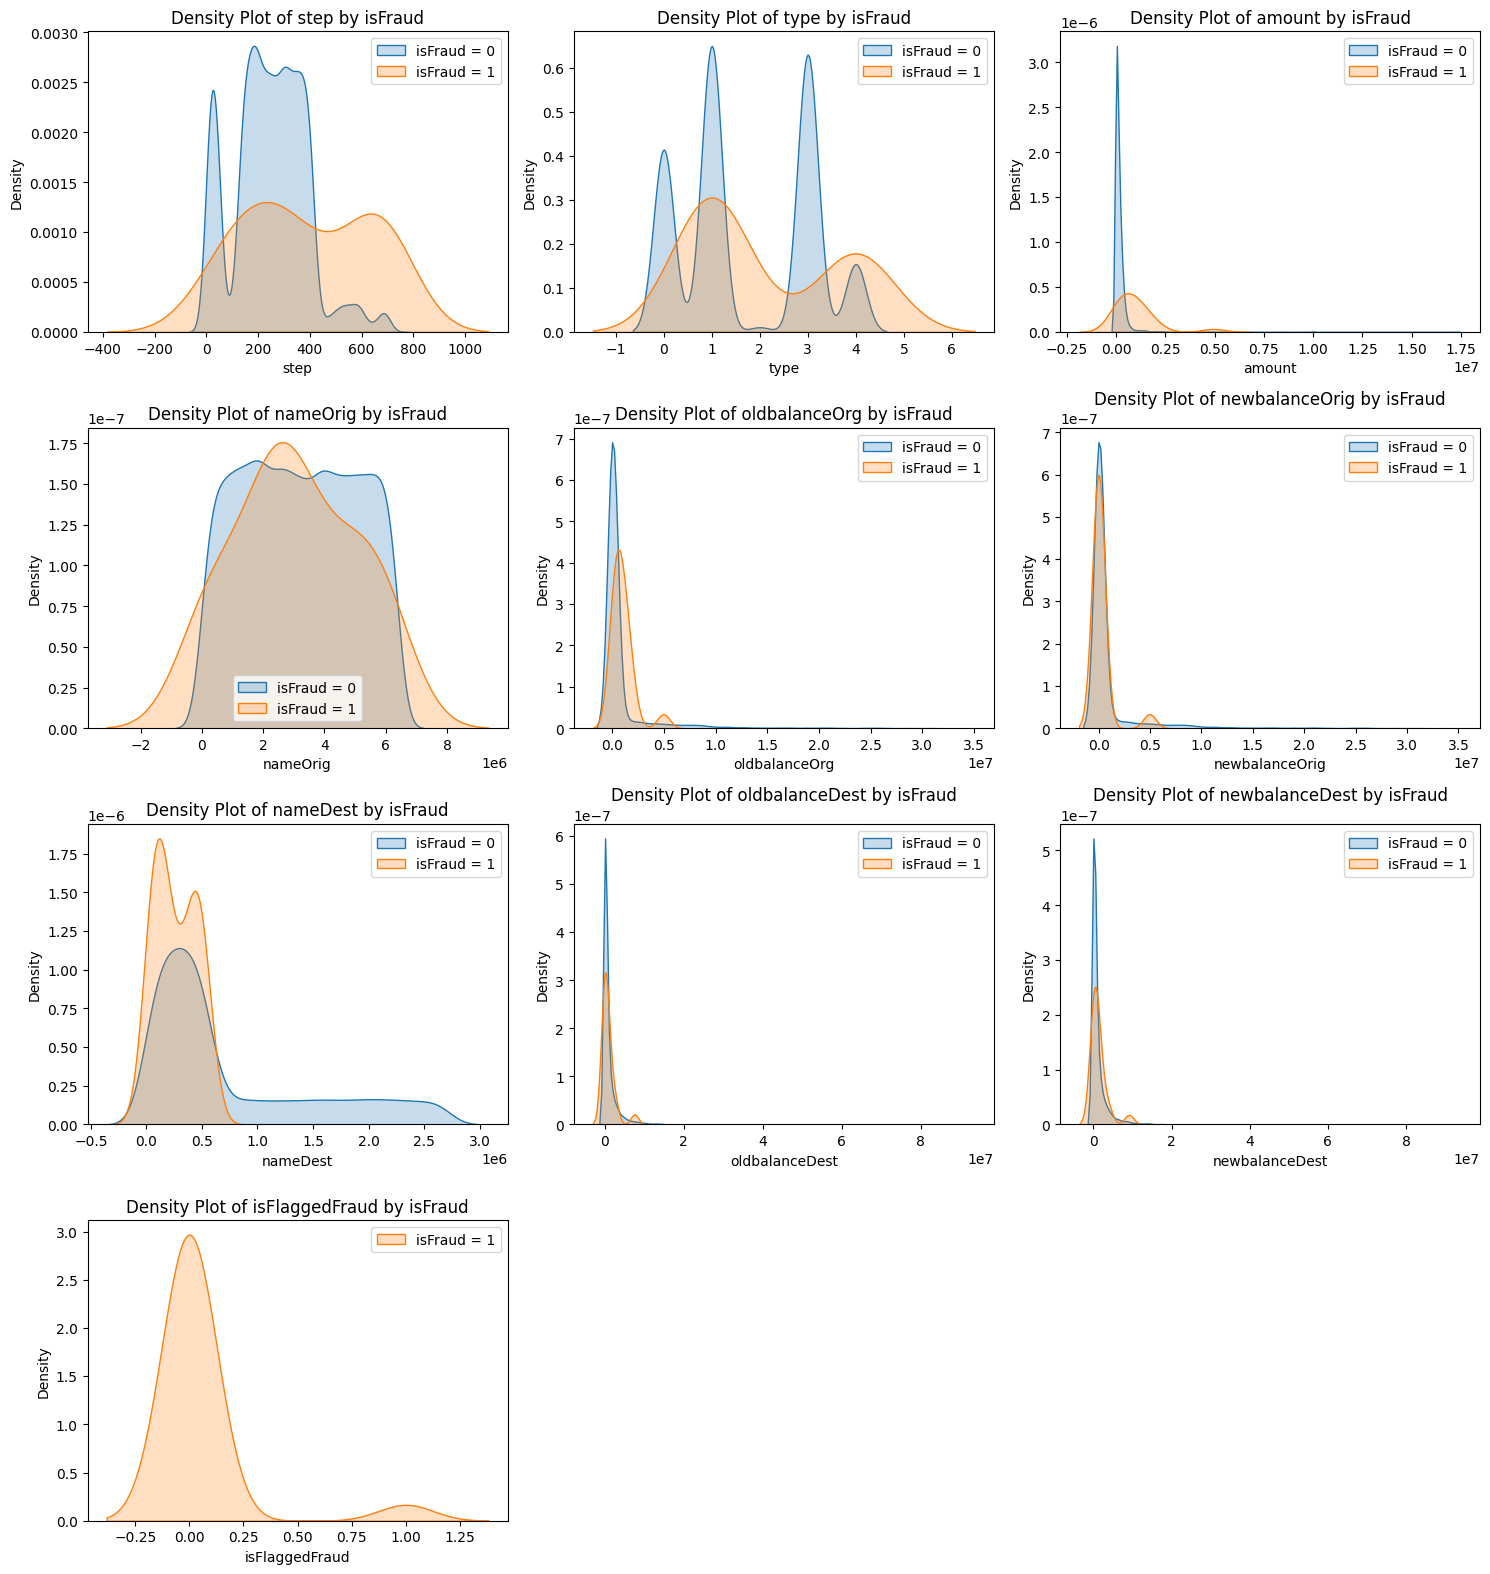

In [92]:
density_plots(df1)

In [93]:
def stripplots(df, target='isFraud', sample_size=5000):
    data = df.sample(n=min(sample_size, len(df)), random_state=42)
    feature_columns = [col for col in df.columns if col != target]
    num_features = len(feature_columns)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()
    for i, col in enumerate(feature_columns):
        sns.stripplot(x=target, y=col, data=data, jitter=True, alpha=0.4, ax=axes[i])
        axes[i].set_title(f"Strip Plot of {col} vs {target}")
        axes[i].set_xlabel(target)
        axes[i].set_ylabel(col)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


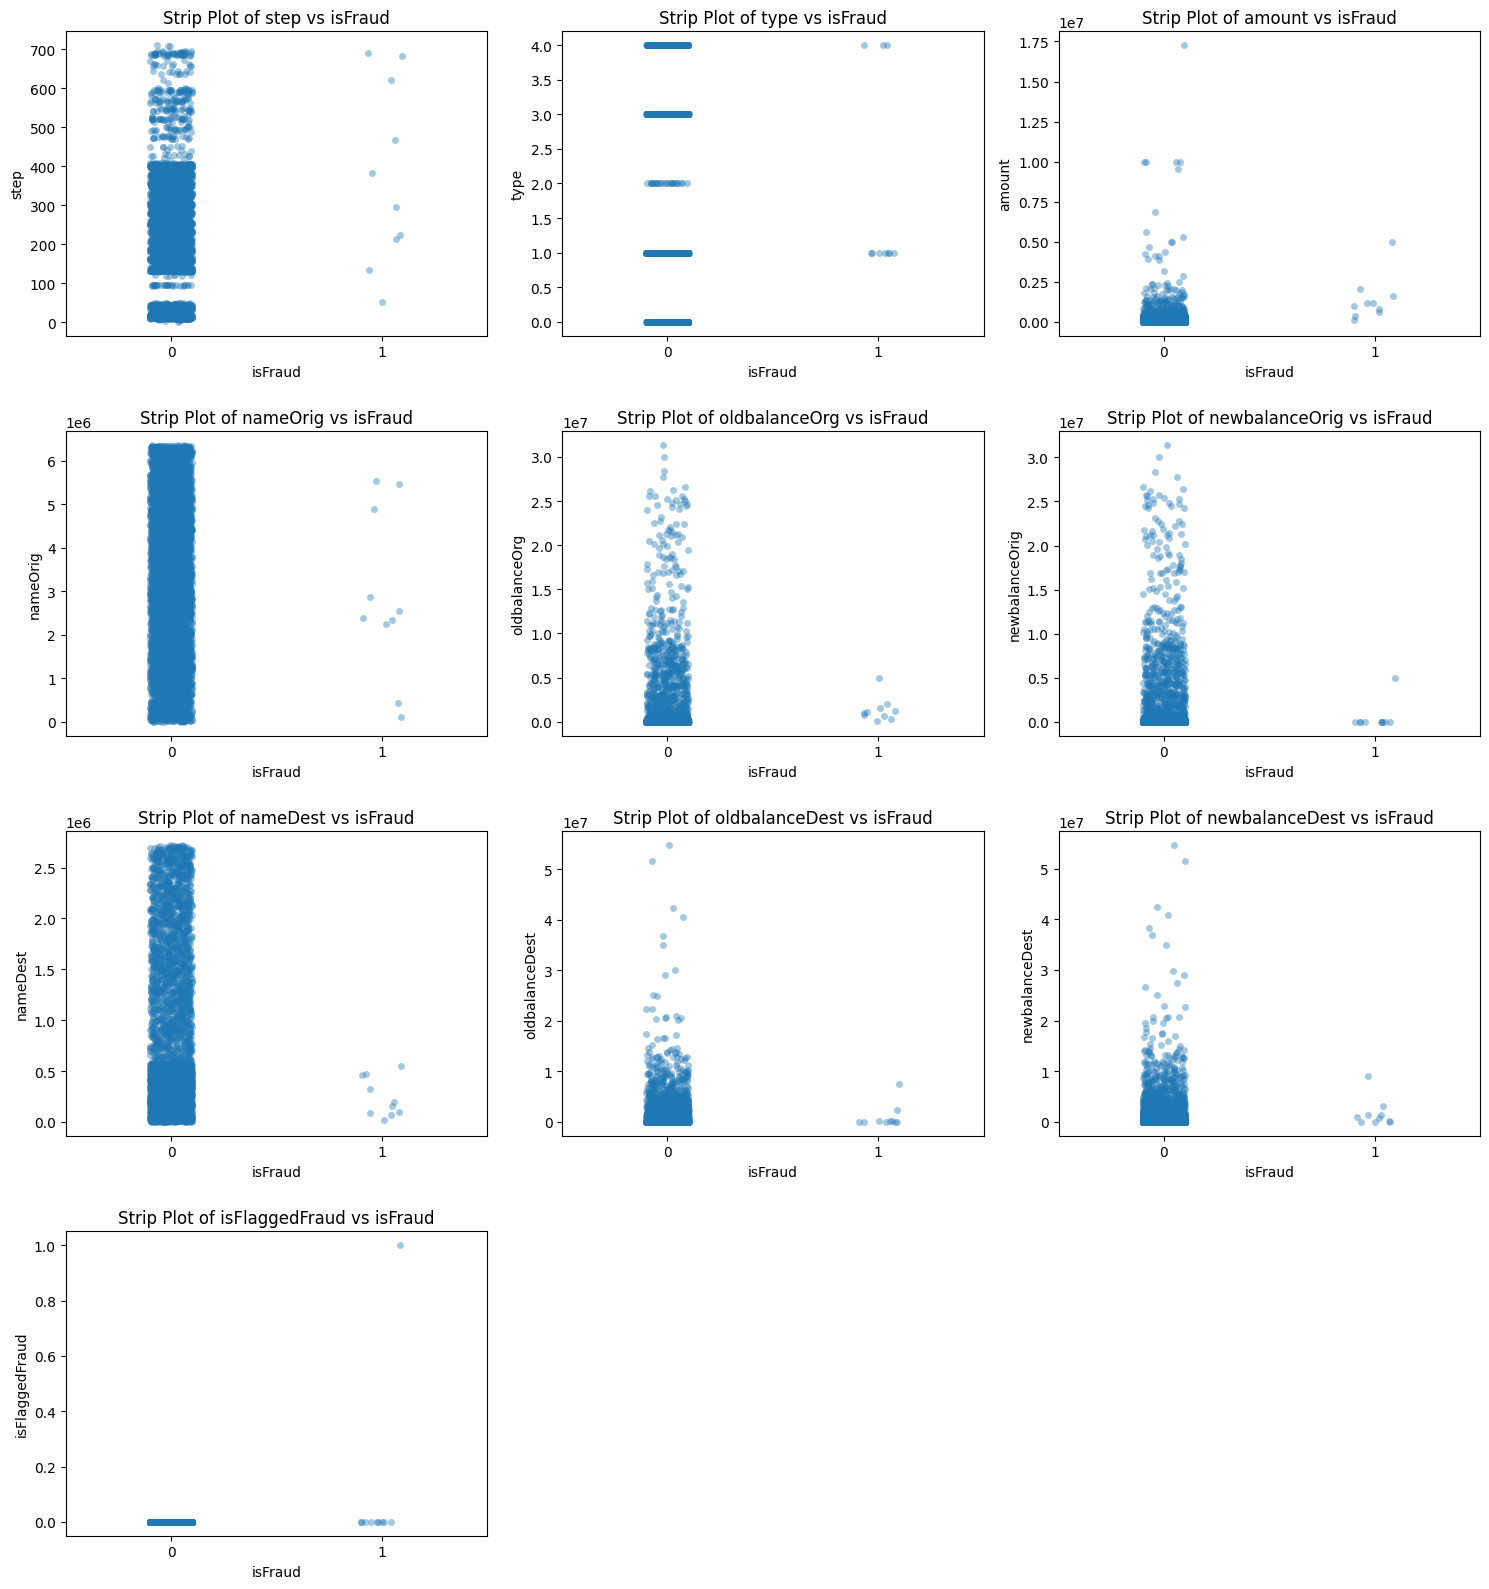

In [94]:
stripplots(df1)

In [95]:
def boxplots(df, target='isFraud', sample_size=10000):
    data = df.sample(n=min(sample_size, len(df)), random_state=42)
    feature_columns = [col for col in df.columns if col != target]
    num_features = len(feature_columns)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()
    for i, col in enumerate(feature_columns):
        sns.boxplot(x=target, y=col, data=data, ax=axes[i])
        axes[i].set_title(f"Boxplot of {col} by {target}")
        axes[i].set_xlabel(target)
        axes[i].set_ylabel(col)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


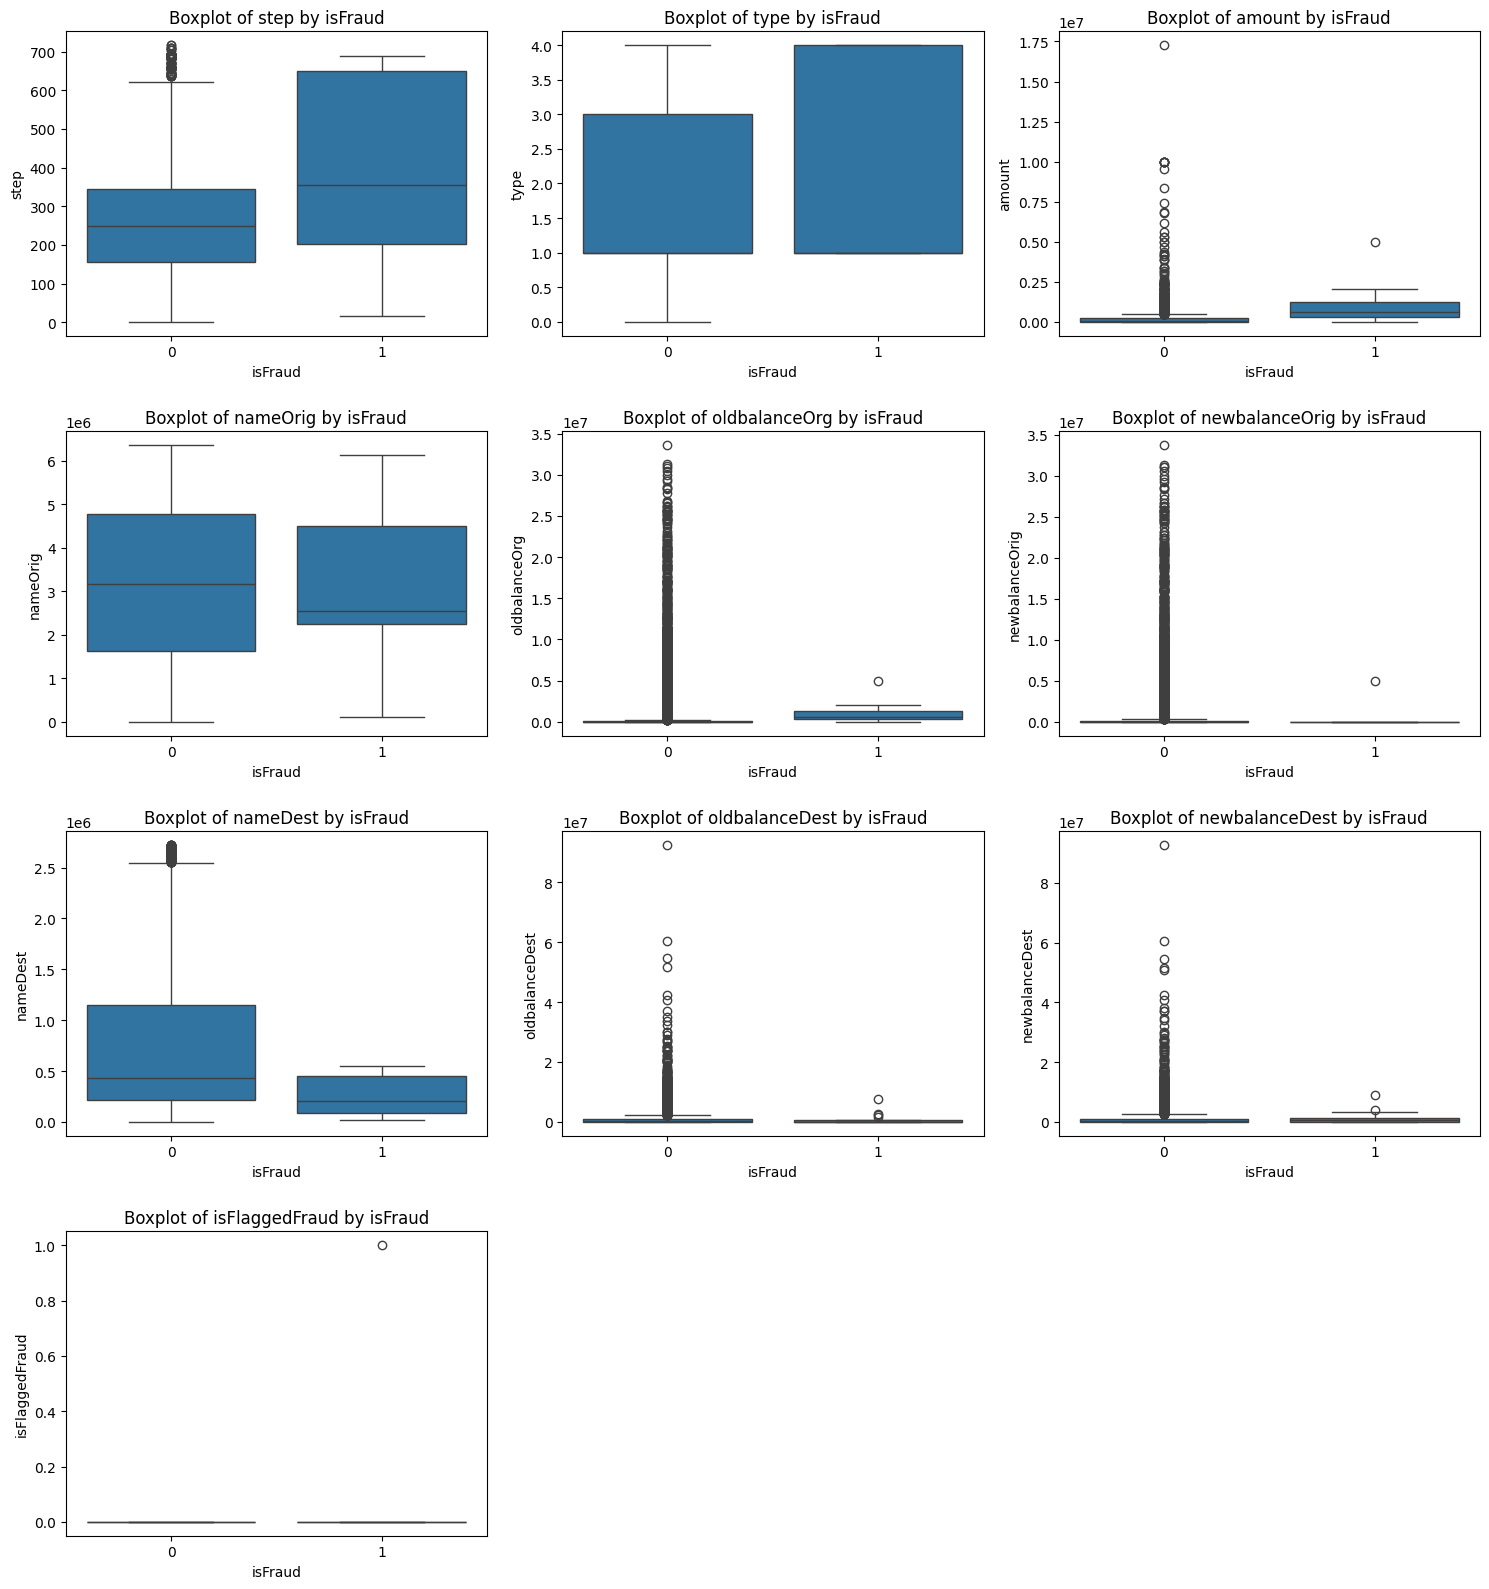

In [96]:
boxplots(df1)

In [99]:
df1['balance_change_orig'] = df1['oldbalanceOrg'] - df1['newbalanceOrig']
df['balance_change_dest'] = df1['newbalanceDest'] - df1['oldbalanceDest']

In [100]:
df1 = df1.drop(columns=['newbalanceOrig', 'oldbalanceOrg', 'newbalanceDest', 'oldbalanceDest'])

In [101]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'nameDest', 'isFraud',
       'isFlaggedFraud', 'balance_change_orig', 'balance_change_dest'],
      dtype='object')

In [102]:
cols_to_scale = ['step', 'type', 'amount', 'nameOrig', 'nameDest','isFlaggedFraud', 'balance_change_orig', 'balance_change_dest']
X = df[cols_to_scale].copy()
X = X.dropna()

# VIF calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               Feature       VIF
0                 step  2.703714
1                 type  4.285066
2               amount  3.898224
3             nameOrig  2.683260
4             nameDest  3.260031
5       isFlaggedFraud  1.000553
6  balance_change_orig  1.142937
7  balance_change_dest  3.729257


In [103]:
ss = StandardScaler()
scaler = StandardScaler()
df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])

df1.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,balance_change_orig,balance_change_dest
0,-1.703042,0.952399,-0.281560,-1.318825,1.220490,0,-0.001586,0.211876,-0.152896
1,-1.703042,0.952399,-0.294767,-0.538520,1.316232,0,-0.001586,0.157490,-0.152896
2,-1.703042,1.693076,-0.297555,-1.185630,-0.408856,1,-0.001586,0.146011,-0.152896
3,-1.703042,-0.528954,-0.297555,1.445742,-0.472820,1,-0.001586,0.146011,-0.178952
4,-1.703042,0.952399,-0.278532,0.146834,0.109953,0,-0.001586,0.224345,-0.152896


In [104]:
x = df[cols_to_scale]
y = df['isFraud']

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42,test_size=0.3,stratify = y)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4453834, 8)
(1908786, 8)
(4453834,)
(1908786,)


In [106]:
print("for training: ", y_train.value_counts())
print("\n for testing : ", y_test.value_counts())

for training:  isFraud
0    4448085
1       5749
Name: count, dtype: int64

 for testing :  isFraud
0    1906322
1       2464
Name: count, dtype: int64


In [107]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print(x_train_smote.shape)
print(y_train_smote.shape)


(8896170, 8)
(8896170,)


In [108]:
y_train_smote.value_counts()

isFraud
0    4448085
1    4448085
Name: count, dtype: int64

In [109]:
nm = NearMiss()
x_train_nm, y_train_nm = nm.fit_resample(x_train, y_train)

In [110]:
y_train_nm.value_counts()

isFraud
0    5749
1    5749
Name: count, dtype: int64

In [111]:
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
spw= neg_count / pos_count

lgb_clf1 = LGBMClassifier(n_estimators=100,max_depth=5,random_state=42,n_jobs=-1,is_unbalance=True)
lgb_clf2 = LGBMClassifier(n_estimators=100,max_depth=5,random_state=42,n_jobs=-1,is_unbalance=True)
lgb_clf3 = LGBMClassifier(n_estimators=100,max_depth=5,random_state=42,n_jobs=-1,is_unbalance=True)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 800x600 with 0 Axes>

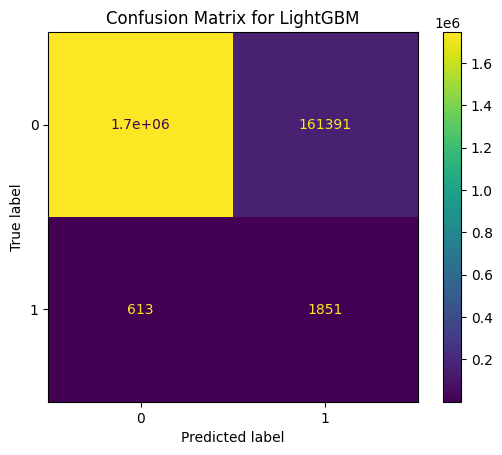

In [112]:
lgb_clf1.fit(x_train, y_train)
y_pred = lgb_clf1.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_clf1.classes_)
disp.plot()
plt.title('Confusion Matrix for LightGBM')
plt.show()

[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 800x600 with 0 Axes>

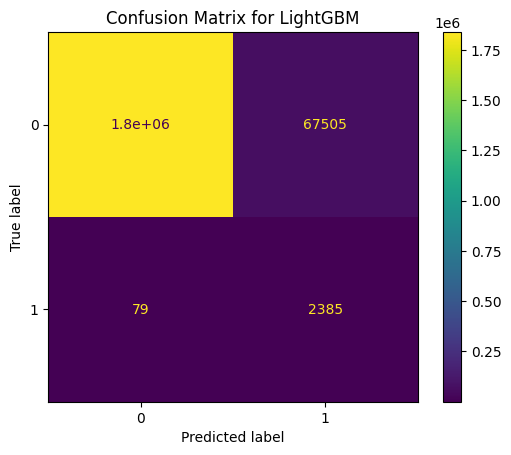

In [113]:
lgb_clf2.fit(x_train_smote, y_train_smote)
y_pred = lgb_clf2.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_clf2.classes_)
disp.plot()
plt.title('Confusion Matrix for LightGBM')
plt.show()

[LightGBM] [Info] Number of positive: 5749, number of negative: 5749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 11498, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

<Figure size 800x600 with 0 Axes>

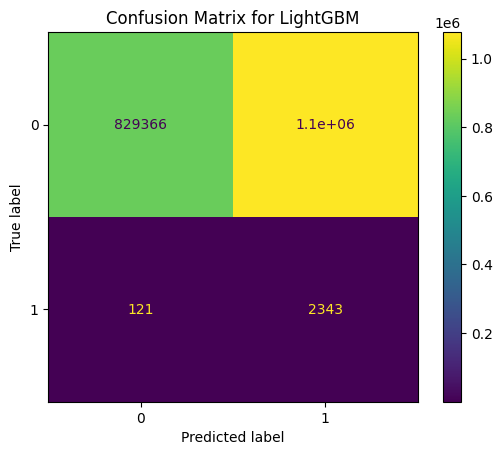

In [114]:
lgb_clf3.fit(x_train_nm, y_train_nm)
y_pred = lgb_clf3.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_clf3.classes_)
disp.plot()
plt.title('Confusion Matrix for LightGBM')
plt.show()

In [115]:
rfc1 = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=10,min_samples_leaf=5,max_features='sqrt',class_weight='balanced',n_jobs=-1)
rfc2 = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=10,min_samples_leaf=5,max_features='sqrt',class_weight='balanced',n_jobs=-1)
rfc3 = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=10,min_samples_leaf=5,max_features='sqrt',class_weight='balanced',n_jobs=-1)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1906322
           1       0.04      0.97      0.07      2464

    accuracy                           0.97   1908786
   macro avg       0.52      0.97      0.53   1908786
weighted avg       1.00      0.97      0.98   1908786



<Figure size 800x600 with 0 Axes>

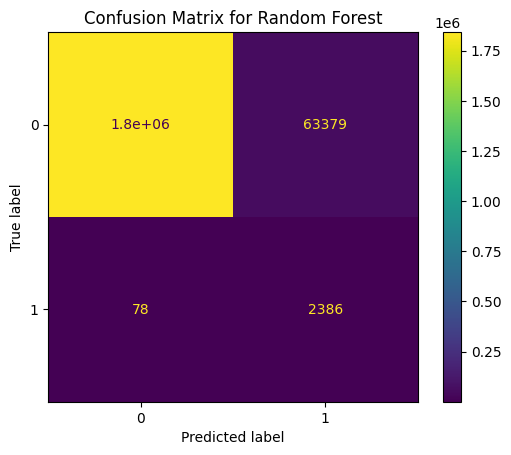

In [116]:
rfc1.fit(x_train, y_train)
y_pred = rfc1.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc1.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.52      0.68   1906322
           1       0.00      0.94      0.00      2464

    accuracy                           0.52   1908786
   macro avg       0.50      0.73      0.34   1908786
weighted avg       1.00      0.52      0.68   1908786



<Figure size 800x600 with 0 Axes>

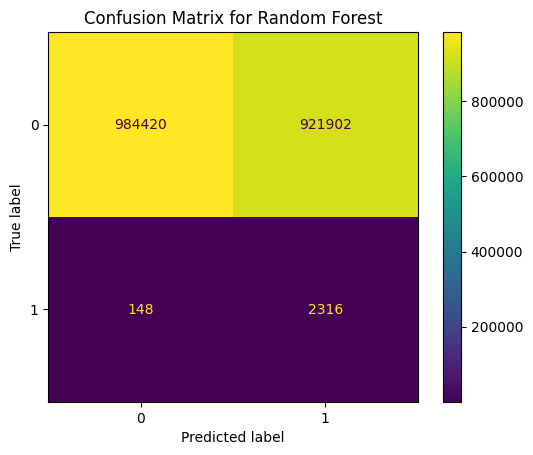

In [117]:
rfc3.fit(x_train_nm,y_train_nm)
y_pred = rfc3.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc3.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [118]:
lr1 = LogisticRegression( class_weight='balanced',solver='saga',max_iter=100,penalty='l2',C=0.1,random_state=42,n_jobs=-1)
lr2 = LogisticRegression( class_weight='balanced',solver='saga',max_iter=100,penalty='l2',C=0.1,random_state=42,n_jobs=-1)
lr3 = LogisticRegression( class_weight='balanced',solver='saga',max_iter=100,penalty='l2',C=0.1,random_state=42,n_jobs=-1)

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1906322
           1       0.02      0.90      0.05      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.93      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



<Figure size 800x600 with 0 Axes>

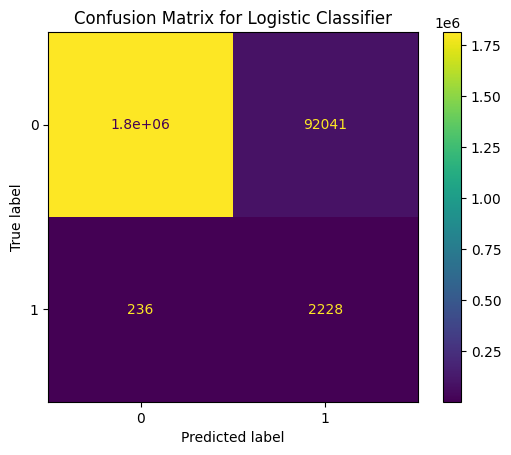

In [119]:
lr1.fit(x_train, y_train)
y_pred = lr1.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr1.classes_)
disp.plot()
plt.title('Confusion Matrix for Logistic Classifier')
plt.show()

In [120]:
cor = df1.corr()
cor_table = cor['isFraud'].sort_values(ascending=False)
print(cor_table)

isFraud                1.000000
balance_change_orig    0.362472
amount                 0.076688
isFlaggedFraud         0.044109
step                   0.031578
balance_change_dest    0.027028
type                   0.020833
nameOrig              -0.000464
nameDest              -0.021963
Name: isFraud, dtype: float64


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1906322
           1       0.02      0.92      0.05      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.93      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



<Figure size 800x600 with 0 Axes>

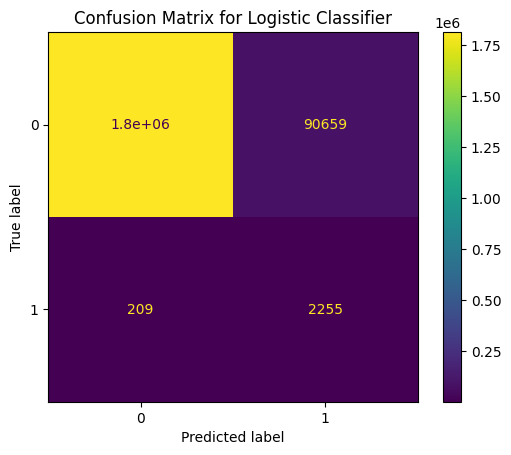

In [121]:
lr2.fit(x_train_smote,y_train_smote)
y_pred = lr2.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr2.classes_)
disp.plot()
plt.title('Confusion Matrix for Logistic Classifier')
plt.show()


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.73      0.84   1906322
           1       0.00      0.84      0.01      2464

    accuracy                           0.73   1908786
   macro avg       0.50      0.78      0.43   1908786
weighted avg       1.00      0.73      0.84   1908786



<Figure size 800x600 with 0 Axes>

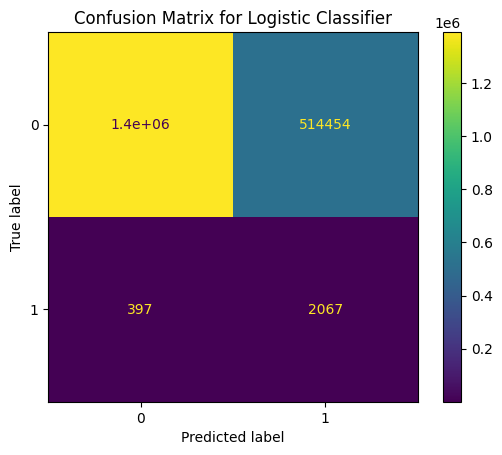

In [122]:
lr3.fit(x_train_nm,y_train_nm)
y_pred = lr3.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr3.classes_)
disp.plot()
plt.title('Confusion Matrix for Logistic Classifier')
plt.show()

In [123]:
xgb1 = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=spw, objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42, verbosity=1)
xgb2 = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=spw, objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42, verbosity=1)
xgb3 = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=spw, objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42, verbosity=1)


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 


              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906322
           1       0.05      0.96      0.09      2464

    accuracy                           0.98   1908786
   macro avg       0.52      0.97      0.54   1908786
weighted avg       1.00      0.98      0.99   1908786



<Figure size 800x600 with 0 Axes>

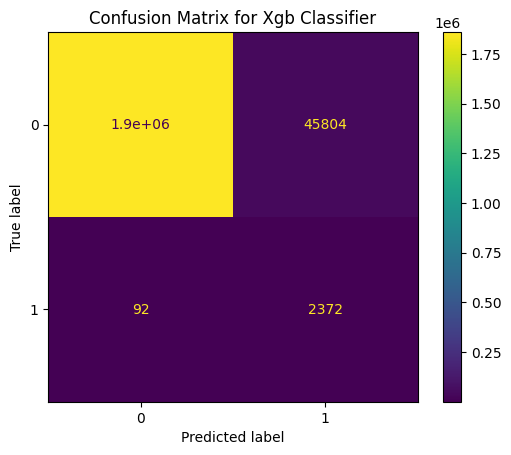

In [124]:
xgb1.fit(x_train, y_train)
y_pred = xgb1.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb1.classes_)
disp.plot()
plt.title('Confusion Matrix for Xgb Classifier')
plt.show()

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_

              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1906322
           1       0.01      0.99      0.02      2464

    accuracy                           0.90   1908786
   macro avg       0.51      0.94      0.49   1908786
weighted avg       1.00      0.90      0.95   1908786



<Figure size 800x600 with 0 Axes>

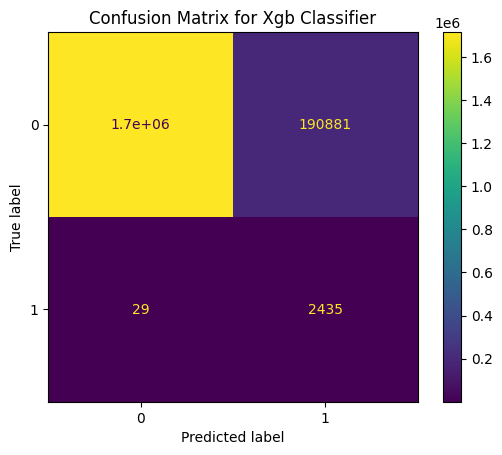

In [125]:
xgb2.fit(x_train_smote,y_train_smote)
y_pred = xgb2.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb2.classes_)
disp.plot()
plt.title('Confusion Matrix for Xgb Classifier')
plt.show()

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_

              precision    recall  f1-score   support

           0       1.00      0.43      0.60   1906322
           1       0.00      0.99      0.00      2464

    accuracy                           0.43   1908786
   macro avg       0.50      0.71      0.30   1908786
weighted avg       1.00      0.43      0.60   1908786



<Figure size 800x600 with 0 Axes>

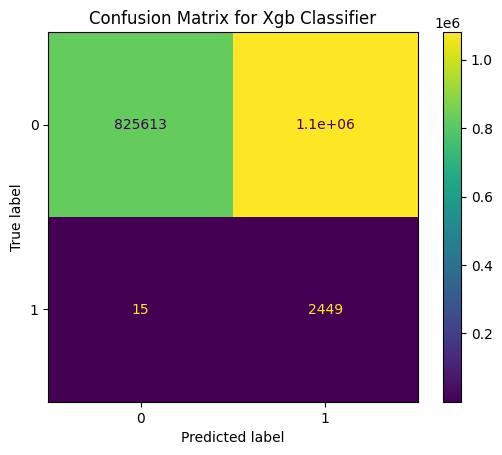

In [126]:
xgb3.fit(x_train_nm,y_train_nm)
y_pred = xgb3.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb3.classes_)
disp.plot()
plt.title('Confusion Matrix for Xgb Classifier')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.97      0.06      2464

    accuracy                           0.96   1908786
   macro avg       0.51      0.96      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786



<Figure size 800x600 with 0 Axes>

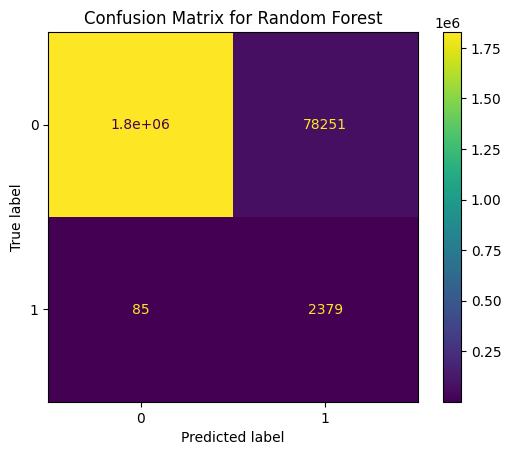

In [127]:
rfc2.fit(x_train_smote,y_train_smote)
y_pred = rfc2.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc2.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [128]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [129]:
lrv = VotingClassifier(estimators=[
    ('simple', lr1),
    ('smote', lr2),
    ('near miss', lr3)
], voting='soft')

# Step 3: Fit the model
lrv.fit(x_train, y_train)
print("for logistic Voting Classifer")

# Step 4: Predict probabilities
y_probs = lrv.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


for logistic Voting Classifer

Threshold = 0.3
[[1708891  197431]
 [     71    2393]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1906322
           1       0.01      0.97      0.02      2464

    accuracy                           0.90   1908786
   macro avg       0.51      0.93      0.48   1908786
weighted avg       1.00      0.90      0.94   1908786


Threshold = 0.35
[[1747047  159275]
 [    100    2364]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1906322
           1       0.01      0.96      0.03      2464

    accuracy                           0.92   1908786
   macro avg       0.51      0.94      0.49   1908786
weighted avg       1.00      0.92      0.96   1908786


Threshold = 0.4
[[1776294  130028]
 [    140    2324]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1906322
           1       0.02      0.94     

In [130]:
xgbv = VotingClassifier(estimators=[
    ('simple', xgb1),
    ('smote', xgb2),
    ('near miss', xgb3)
], voting='soft')

# Step 3: Fit the model
xgbv.fit(x_train, y_train)
print("for XGB Voting Classifer")

# Step 4: Predict probabilities
y_probs = xgbv.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_

for XGB Voting Classifer


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autos


Threshold = 0.3
[[1830271   76051]
 [     38    2426]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.98      0.06      2464

    accuracy                           0.96   1908786
   macro avg       0.52      0.97      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786


Threshold = 0.35
[[1837336   68986]
 [     45    2419]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.98      0.07      2464

    accuracy                           0.96   1908786
   macro avg       0.52      0.97      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786


Threshold = 0.4
[[1844956   61366]
 [     66    2398]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1906322
           1       0.04      0.97      0.07      2464

    accuracy 

In [131]:
lgbv = VotingClassifier(estimators=[
    ('simple', lgb_clf1),
    ('smote', lgb_clf2),
    ('near miss', lgb_clf3)
], voting='soft')

# Step 3: Fit the model
lgbv.fit(x_train, y_train)
print("for Light GBM Voting Classifer")

# Step 4: Predict probabilities
y_probs = lgbv.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
lrs = StackingClassifier(estimators=[
    ('simple', lr1),
    ('smote', lr2),
    ('near miss', lr3)
], final_estimator=LogisticRegression(class_weight='balanced', max_iter=100, solver='saga'))

# Step 3: Fit the model
lrs.fit(x_train, y_train)
print("for logistic Stacking Classifer")

# Step 4: Predict probabilities
y_probs = lrs.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

In [ ]:
xgbs = StackingClassifier(estimators=[
    ('simple', xgb1),
    ('smote', xgb2),
    ('near miss', xgb3)
], final_estimator=LogisticRegression(class_weight='balanced', max_iter=100, solver='saga'))

# Step 3: Fit the model
xgbs.fit(x_train, y_train)
print("for XGB Voting Classifer")

# Step 4: Predict probabilities
y_probs = xgbs.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

In [ ]:
lgbs = StackingClassifier(estimators=[
    ('simple', lgb_clf1),
    ('smote', lgb_clf2),
    ('near miss', lgb_clf3)
], final_estimator=LogisticRegression(class_weight='balanced', max_iter=100, solver='saga'))

# Step 3: Fit the model
lgbs.fit(x_train, y_train)
print("for Light GBM Voting Classifer")

# Step 4: Predict probabilities
y_probs = lgbs.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

In [ ]:
rfcs = StackingClassifier(estimators=[
    ('simple', rfc1),
    ('smote', rfc2),
    ('near miss', rfc3)
], final_estimator=LogisticRegression(class_weight='balanced', max_iter=100, solver='saga'))

# Step 3: Fit the model
rfcs.fit(x_train, y_train)
print("for Random Forest Voting Classifer")

# Step 4: Predict probabilities
y_probs = rfcs.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

In [ ]:
rfcv = VotingClassifier(estimators=[
    ('simple', rfc1),
    ('smote', rfc2),
    ('near miss', rfc3)
], voting='soft')

# Step 3: Fit the model
rfcv.fit(x_train, y_train)
print("for Random Forest Voting Classifer")

# Step 4: Predict probabilities
y_probs = rfcv.predict_proba(x_test)[:, 1]  # Probability of class 1

# Step 5: Test for multiple thresholds
thresholds = [0.3, 0.35, 0.4, 0.45]

for thresh in thresholds:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))